# Imports and preliminaries


In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
# import pickle
import json
import os

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
dtype = torch.float

print(device)

cuda


# Trading Model

Here we define the aspects of the problem.

In [ ]:
# The variables of the trading with the crowd are:

# Inventory X for each player
# Price distortion Y (mean over players)
# Exogeneous price P
# Exogenous price drift I

# Each player selects an action u to buy or sell


class TradingModel():

  def __init__(self, control_model, device=torch.device("cuda"), dtype=torch.float,
               T_idx=80, N=30, batch_size=1280, T=10.0, sigma=0.5, beta=0.1, kappa=1.0,
               gamma=1.0, rho=1.0, lamda=0.5, phi=0.1, varrho=10, I_0=0.1, P_0=0,
               Y_0=0, X_0_mean=10.0, X_0_std=10.0, alpha=1.0):
    self.T_idx = T_idx  # Number of time steps
    self.T = T  # Time horizon
    self.dt = torch.tensor(T /  T_idx, device=device, dtype=dtype)
    self.N = N  # Number of agents in simulation
    self.batch_size = batch_size  # Number of batches to be computed simultaneously
    self.control_model = control_model  # Parameterized model of control (torch.NN subclass)
    self.device = device
    self.dtype = dtype

    self.sigma = sigma  # diffusion constant for P and I
    self.beta = beta  # relaxation coefficient in Ornstein-Ulhenbeck process for I
    self.kappa = kappa  # price distortion coefficient
    self.gamma = gamma  # effect of control on price distortion
    self.rho = rho  # relaxation coefficient for price distortion Y
    self.lamda = lamda  # coeffient to immediate price effect of control
    self.phi = phi  # coeffient to running cost of surplus / deficit inventory
    self.varrho = varrho  # terminal penalization of surplus / deficit inventory
    self.I_0 = I_0
    self.P_0 = P_0  
    self.Y_0 = Y_0 
    self.X_0_mean = X_0_mean  
    self.X_0_std = X_0_std

    self.alpha = alpha  # exponent of immediate price effect of control


# the following two methods reshape the intputs into a form that can be read by
# the a control model, NN subclass that takes a 6 dimensional input.

# In fact, the exact solution does not depend on P, and X_bar_t can be determined
# from t.  It is not clear whether it helps or hurts to include these extra inputs
# (or does not really matter).
  def inputs(self, t_idx, I_t, P_t, X_t, Y_t, X_bar_t):
    return torch.cat((torch.broadcast_to(t_idx * self.dt, X_t.shape), \
                      torch.broadcast_to(I_t, X_t.shape), \
                      torch.broadcast_to(P_t, X_t.shape), \
                      X_t, \
                      torch.broadcast_to(Y_t, X_t.shape), \
                      torch.broadcast_to(X_bar_t, X_t.shape))).view(6, -1).t()
                      
  def control(self, t_idx, I_t, P_t, X_t, Y_t):
    return self.control_model(self.inputs(t_idx, I_t, P_t, X_t, Y_t, X_t.mean(0))).t().view(1, self.N, -1)

# The following methods update the equation.  
  def update_P(self, P, I):
    return P + \
              self.sigma * self.dt.sqrt() * torch.randn((1, self.batch_size), device=self.device, dtype=self.dtype) + \
              I * self.dt


  def update_I(self, I): 
    return I + \
              -self.beta * I * self.dt + \
              self.sigma * self.dt.sqrt() * torch.randn((1, self.batch_size), device=self.device, dtype=self.dtype)


  def update_X(self, X, u):   
    return X + \
              -u * self.dt    


  def update_Y(self, Y, u):    
    return Y + \
              -self.rho * Y * self.dt + \
              self.gamma * (u.sign() * u.abs() ** self.alpha).mean(axis=1).detach() * self.dt
              # detach so MFG and not MFC

# The running cost of the model
  def running_cost(self, P, X, Y, u):
    return (-(P - self.kappa * Y) * u + self.lamda * u.abs() ** (self.alpha + 1) + \
              self.phi * X.square() ) * self.dt

# The terminal cost of the model
  def terminal_cost(self, P_T, X_T, Y_T):
    # terminal cost was changed in update to paper
    return -X_T * (P_T - self.kappa * Y_T) + \
              self.varrho * X_T.square()

# Initialization of X, for the deterministic problem without randomness we do a uniform rather than random initialization
  def init_X(self):
    if self.sigma == 0:
      X = torch.linspace(self.X_0_mean - 3 ** 0.5 * self.X_0_std,
                         self.X_0_mean + 3 ** 0.5 * self.X_0_std, self.N,
                         device=self.device, dtype=self.dtype).reshape(1, self.N, 1)
      X = torch.broadcast_to(X, (1, self.N, self.batch_size))

    else:
      X = self.X_0_std * torch.randn((1, self.N, self.batch_size), device=self.device, dtype=self.dtype) + self.X_0_mean
    return X
          

# Sample of the dynamics
  def sample(self):

    X = self.init_X()

    P = self.P_0 * torch.ones((1, self.batch_size), device=self.device, dtype=self.dtype)
    Y = self.Y_0 * torch.ones((1, self.batch_size), device=self.device, dtype=self.dtype)
    I = self.I_0 * torch.ones((1, self.batch_size), device=self.device, dtype=self.dtype)

    l = torch.zeros((1, self.N, self.batch_size), device=self.device, dtype=self.dtype)  # cost

    for t_idx in range(self.T_idx): 

      u = self.control(t_idx, I[t_idx], P[t_idx], X[t_idx], Y[t_idx])
      I = torch.cat((I,
            self.update_I(I[t_idx])), 0)

      P = torch.cat((P,
            self.update_P(P[t_idx], I[t_idx])), 0)

      X = torch.cat((X, 
            self.update_X(X[t_idx], u)), 0)
          
      Y = torch.cat((Y,
            self.update_Y(Y[t_idx], u)), 0)

      l = l + self.running_cost(P[t_idx], X[t_idx], Y[t_idx], u)

    return I, P, X, Y, l
    
# Sample only the signal (I, P) dynamics
  def sample_signal(self):

    P = self.P_0 * torch.ones((1, self.batch_size), device=self.device, dtype=self.dtype)
    I = self.I_0 * torch.ones((1, self.batch_size), device=self.device, dtype=self.dtype)


    for t_idx in range(self.T_idx): 
      I = torch.cat((I,
            self.update_I(I[t_idx])), 0)

      P = torch.cat((P,
            self.update_P(P[t_idx], I[t_idx])), 0)

    return I, P

  def sample_from_signal(self, X_0, I, P):
    X = X_0

    Y = self.Y_0 * torch.ones((1, self.batch_size), device=self.device, dtype=self.dtype)

    l = torch.zeros((1, self.N, self.batch_size), device=self.device, dtype=self.dtype) 

    for t_idx in range(self.T_idx):   
      X = torch.cat((X, 
            self.update_X(X[t_idx], self.control(t_idx, I[t_idx], P[t_idx], X[t_idx], Y[t_idx]))), 0)
          
      Y = torch.cat((Y,
            self.update_Y(Y[t_idx], self.control(t_idx, I[t_idx], P[t_idx], X[t_idx], Y[t_idx]))), 0)

      l = l + self.running_cost(P[t_idx], X[t_idx], Y[t_idx], self.control(t_idx, I[t_idx], P[t_idx], X[t_idx], Y[t_idx]))

    return X, Y, l

  def cost(self):
    I, P, X, Y, l = self.sample()

    l = l + self.terminal_cost(P[self.T_idx], X[self.T_idx], Y[self.T_idx])

    return l.mean()



# Neural Network

The neural network is completey independent from the Trading Model except for agreeing with the inputs and outputs

In [ ]:
#  An attempt to be a very standard deep feed forward neural network.

class FFNet(nn.Module):
    def __init__(self, sigma=nn.Tanh()):
        super().__init__()
        self.fc1 = nn.Linear(6, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 1, bias=False)

        self.sigma = sigma

    def forward(self, x):
        x1 = self.sigma(self.fc1(x))
        x2 = self.sigma(self.fc2(x1))
        x3 = self.sigma(self.fc3(x2))
        return self.fc4(x3)


# Exact solution auxilliary functions


In [ ]:
# Calculations from Section 11.2 of "Trading with the Crowd" by Eyal Neuman and Moritz Voss.

def aTilde(kappa, rho, gamma, lamda, phi, varrho):
  
  return (2 * lamda * rho + gamma * kappa)/(2 * lamda)

def bTilde(kappa, rho, gamma, lamda, phi, varrho):
  
  return (-phi/lamda)

def cTilde(kappa, rho, gamma, lamda, phi, varrho):
  
  return (-phi * rho/lamda)

def pTilde(kappa, rho, gamma, lamda, phi, varrho):
  
  return bTilde(kappa, rho, gamma, lamda, phi, varrho) - 1/3 * aTilde(kappa, rho, gamma, lamda, phi, varrho)**2


def qTilde(kappa, rho, gamma, lamda, phi, varrho):
  
  return 2/27 * aTilde(kappa, rho, gamma, lamda, phi, varrho)**3 - \
          1/3 * aTilde(kappa, rho, gamma, lamda, phi, varrho) * bTilde(kappa, rho, gamma, lamda, phi, varrho) + \
          cTilde(kappa, rho, gamma, lamda, phi, varrho)

def nuTilde1(kappa, rho, gamma, lamda, phi, varrho):

  return (-1) * np.sqrt(-4/3 * pTilde(kappa, rho, gamma, lamda, phi, varrho)) * \
          np.cos(1/3 * np.arccos(-qTilde(kappa, rho, gamma, lamda, phi, varrho)/2 * \
                                 np.sqrt(-27/pTilde(kappa, rho, gamma, lamda, phi, varrho)**3)) + np.pi/3) - \
          aTilde(kappa, rho, gamma, lamda, phi, varrho)/3

def nuTilde2(kappa, rho, gamma, lamda, phi, varrho):
  
  return np.sqrt(-4/3 * pTilde(kappa, rho, gamma, lamda, phi, varrho)) * \
          np.cos(1/3 * np.arccos(-qTilde(kappa, rho, gamma, lamda, phi, varrho)/2 * \
                                 np.sqrt(-27/pTilde(kappa, rho, gamma, lamda, phi, varrho)**3))) - \
          aTilde(kappa, rho, gamma, lamda, phi, varrho)/3

def nuTilde3(kappa, rho, gamma, lamda, phi, varrho):

  return (-1) * np.sqrt(-4/3 * pTilde(kappa, rho, gamma, lamda, phi, varrho)) * \
          np.cos(1/3 * np.arccos(-qTilde(kappa, rho, gamma, lamda, phi, varrho)/2 * \
                                 np.sqrt(-27/pTilde(kappa, rho, gamma, lamda, phi, varrho)**3)) - np.pi/3) - \
          aTilde(kappa, rho, gamma, lamda, phi, varrho)/3

def nuTilde12(kappa, rho, gamma, lamda, phi, varrho):

  return nuTilde1(kappa, rho, gamma, lamda, phi, varrho) - nuTilde2(kappa, rho, gamma, lamda, phi, varrho)
  

def nuTilde13(kappa, rho, gamma, lamda, phi, varrho):

  return nuTilde1(kappa, rho, gamma, lamda, phi, varrho) - nuTilde3(kappa, rho, gamma, lamda, phi, varrho)
  

def nuTilde23(kappa, rho, gamma, lamda, phi, varrho):

  return nuTilde2(kappa, rho, gamma, lamda, phi, varrho) - nuTilde3(kappa, rho, gamma, lamda, phi, varrho)
  

# Define the auxiliary functions $\tilde K_1, \tilde K_2, \tilde K_3$ from (11.22), (11.23), (11.24):

def KTilde1(t, T, kappa, rho, gamma, lamda, phi, varrho):

  return phi/(2 * lamda**2) * \
          ( (2 * varrho * (nuTilde1(kappa, rho, gamma, lamda, phi, varrho) + rho) + \
             kappa * gamma * nuTilde1(kappa, rho, gamma, lamda, phi, varrho) + \
             2 * lamda * nuTilde1(kappa, rho, gamma, lamda, phi, varrho) * \
             (nuTilde1(kappa, rho, gamma, lamda, phi, varrho) + rho)) / \
           (nuTilde1(kappa, rho, gamma, lamda, phi, varrho) * \
            nuTilde12(kappa, rho, gamma, lamda, phi, varrho) * \
            nuTilde13(kappa, rho, gamma, lamda, phi, varrho)) * \
           np.exp(nuTilde1(kappa, rho, gamma, lamda, phi, varrho) * (T - t)) \
           - (2 * varrho * (nuTilde2(kappa, rho, gamma, lamda, phi, varrho) + rho) + \
             kappa * gamma * nuTilde2(kappa, rho, gamma, lamda, phi, varrho) + \
             2 * lamda * nuTilde2(kappa, rho, gamma, lamda, phi, varrho) * \
             (nuTilde2(kappa, rho, gamma, lamda, phi, varrho) + rho)) / \
           (nuTilde2(kappa, rho, gamma, lamda, phi, varrho) * \
            nuTilde12(kappa, rho, gamma, lamda, phi, varrho) * \
            nuTilde23(kappa, rho, gamma, lamda, phi, varrho)) * \
           np.exp(nuTilde2(kappa, rho, gamma, lamda, phi, varrho) * (T - t)) \
           + (2 * varrho * (nuTilde3(kappa, rho, gamma, lamda, phi, varrho) + rho) + \
             kappa * gamma * nuTilde3(kappa, rho, gamma, lamda, phi, varrho) + \
             2 * lamda * nuTilde3(kappa, rho, gamma, lamda, phi, varrho) * \
             (nuTilde3(kappa, rho, gamma, lamda, phi, varrho) + rho)) / \
           (nuTilde3(kappa, rho, gamma, lamda, phi, varrho) * \
            nuTilde13(kappa, rho, gamma, lamda, phi, varrho) * \
            nuTilde23(kappa, rho, gamma, lamda, phi, varrho)) * \
           np.exp(nuTilde3(kappa, rho, gamma, lamda, phi, varrho) * (T - t)))

def KTilde2(t, T, kappa, rho, gamma, lamda, phi, varrho):

  return 1/(2 * gamma * lamda * rho) * \
      (((2 * varrho * (nuTilde1(kappa, rho, gamma, lamda, phi, varrho) + rho) + \
         kappa * gamma * nuTilde1(kappa, rho, gamma, lamda, phi, varrho) + \
         2 * lamda * nuTilde1(kappa, rho, gamma, lamda, phi, varrho) * \
         (nuTilde1(kappa, rho, gamma, lamda, phi, varrho) + rho)) * \
        (nuTilde2(kappa, rho, gamma, lamda, phi, varrho) + rho) * \
        (nuTilde3(kappa, rho, gamma, lamda, phi, varrho) + rho)) / \
       (nuTilde12(kappa, rho, gamma, lamda, phi, varrho) * \
        nuTilde13(kappa, rho, gamma, lamda, phi, varrho)) * \
       np.exp(nuTilde1(kappa, rho, gamma, lamda, phi, varrho) * (T - t)) \
       - ((2 * varrho * (nuTilde2(kappa, rho, gamma, lamda, phi, varrho) + rho) + \
           kappa * gamma * nuTilde2(kappa, rho, gamma, lamda, phi, varrho) + \
           2 * lamda * nuTilde2(kappa, rho, gamma, lamda, phi, varrho) * \
           (nuTilde2(kappa, rho, gamma, lamda, phi, varrho) + rho)) * \
          (nuTilde1(kappa, rho, gamma, lamda, phi, varrho) + rho) * \
          (nuTilde3(kappa, rho, gamma, lamda, phi, varrho) + rho)) / \
       (nuTilde12(kappa, rho, gamma, lamda, phi, varrho) * \
        nuTilde23(kappa, rho, gamma, lamda, phi, varrho)) * \
       np.exp(nuTilde2(kappa, rho, gamma, lamda, phi, varrho) * (T - t)) \
       + ((2 * varrho * (nuTilde3(kappa, rho, gamma, lamda, phi, varrho) + rho) + \
           kappa * gamma * nuTilde3(kappa, rho, gamma, lamda, phi, varrho) + \
           2 * lamda * nuTilde3(kappa, rho, gamma, lamda, phi, varrho) * \
           (nuTilde3(kappa, rho, gamma, lamda, phi, varrho) + rho)) * \
          (nuTilde1(kappa, rho, gamma, lamda, phi, varrho) + rho) * \
          (nuTilde2(kappa, rho, gamma, lamda, phi, varrho) + rho)) / \
       (nuTilde13(kappa, rho, gamma, lamda, phi, varrho) * \
        nuTilde23(kappa, rho, gamma, lamda, phi, varrho)) * \
       np.exp(nuTilde3(kappa, rho, gamma, lamda, phi, varrho) * (T - t)))

def KTilde3(t, T, kappa, rho, gamma, lamda, phi, varrho):

  return 1/(2 * lamda) * \
          (-(2 * varrho * (nuTilde1(kappa, rho, gamma, lamda, phi, varrho) + rho) + \
             kappa * gamma * nuTilde1(kappa, rho, gamma, lamda, phi, varrho) + \
             2 * lamda * nuTilde1(kappa, rho, gamma, lamda, phi, varrho) * \
             (nuTilde1(kappa, rho, gamma, lamda, phi, varrho) + rho)) / \
           (nuTilde12(kappa, rho, gamma, lamda, phi, varrho) * \
            nuTilde13(kappa, rho, gamma, lamda, phi, varrho)) * \
           np.exp(nuTilde1(kappa, rho, gamma, lamda, phi, varrho) * (T - t)) \
           + (2 * varrho * (nuTilde2(kappa, rho, gamma, lamda, phi, varrho) + rho) + \
              kappa * gamma * nuTilde2(kappa, rho, gamma, lamda, phi, varrho) + \
              2 * lamda * nuTilde2(kappa, rho, gamma, lamda, phi, varrho) * \
              (nuTilde2(kappa, rho, gamma, lamda, phi, varrho) + rho)) / \
           (nuTilde12(kappa, rho, gamma, lamda, phi, varrho) * \
            nuTilde23(kappa, rho, gamma, lamda, phi, varrho)) * \
           np.exp(nuTilde2(kappa, rho, gamma, lamda, phi, varrho) * (T - t)) \
           - (2 * varrho * (nuTilde3(kappa, rho, gamma, lamda, phi, varrho) + rho) + \
              kappa * gamma * nuTilde3(kappa, rho, gamma, lamda, phi, varrho) + \
              2 * lamda * nuTilde3(kappa, rho, gamma, lamda, phi, varrho) * \
              (nuTilde3(kappa, rho, gamma, lamda, phi, varrho) + rho)) / \
           (nuTilde13(kappa, rho, gamma, lamda, phi, varrho) * \
            nuTilde23(kappa, rho, gamma, lamda, phi, varrho)) * \
            np.exp(nuTilde3(kappa, rho, gamma, lamda, phi, varrho) * (T - t)))

# Define the auxiliary functions $\tilde w_1, \tilde w_2$ from (3.16):

def wTilde1(t, T, kappa, rho, gamma, lamda, phi, varrho):
  
  return (-1) * KTilde1(t, T, kappa, rho, gamma, lamda, phi, varrho)/ \
                  KTilde3(t, T, kappa, rho, gamma, lamda, phi, varrho)

def wTilde2(t, T, kappa, rho, gamma, lamda, phi, varrho):
  
  return (-1) * KTilde2(t, T, kappa, rho, gamma, lamda, phi, varrho)/ \
                  KTilde3(t, T, kappa, rho, gamma, lamda, phi, varrho)
                  

#  Define the auxiliary functions $R$ and $R'$ from (3.19):

def R(t, T, kappa, rho, gamma, lamda, phi, varrho):

  return np.sqrt(phi/lamda) * np.cosh(np.sqrt(phi/lamda) * (T - t)) + \
          varrho/lamda * np.sinh(np.sqrt(phi/lamda) * (T - t))

def Rprime(t, T, kappa, rho, gamma, lamda, phi, varrho):

  return phi/lamda * np.sinh(np.sqrt(phi/lamda) * (T - t)) + \
          varrho/lamda * np.sqrt(phi/lamda) * np.cosh(np.sqrt(phi/lamda) * (T - t))

# Introduce the process $(\tilde\zeta_t)_{0 \leq t \leq T}$ defined as 

# $$ \zeta_t := -\frac{1}{2\lambda} \mathbb{E}_t\left[\int_t^T \frac{\tilde K_3(T-s)}{\tilde K_3(T-t)} dA_s \right] \quad (0 \leq t \leq T),$$

# where $dA_s = I_s ds$ and $dI_s = -\beta I_s ds + \sigma dW_s$ (cf. equation (3.18)).
#           

def zetaTilde(t, T, kappa, rho, gamma, lamda, phi, varrho, beta, I):

  return (-1)/(4 * lamda**2 * KTilde3(t, T, kappa, rho, gamma, lamda, phi, varrho)) * I * \
      ((2 * varrho * (nuTilde1(kappa, rho, gamma, lamda, phi, varrho) + rho) + \
        kappa * gamma * nuTilde1(kappa, rho, gamma, lamda, phi, varrho) + \
        2 * lamda * nuTilde1(kappa, rho, gamma, lamda, phi, varrho) * \
        (nuTilde1(kappa, rho, gamma, lamda, phi, varrho) + rho)) / \
       (nuTilde12(kappa, rho, gamma, lamda, phi, varrho) * \
        nuTilde13(kappa, rho, gamma, lamda, phi, varrho) * \
        (nuTilde1(kappa, rho, gamma, lamda, phi, varrho) + beta)) * \
       (np.exp(-beta * (T - t)) - np.exp((T - t) * nuTilde1(kappa, rho, gamma, lamda, phi, varrho))) \
       - (2 * varrho * (nuTilde2(kappa, rho, gamma, lamda, phi, varrho) + rho) + \
          kappa * gamma * nuTilde2(kappa, rho, gamma, lamda, phi, varrho) + \
          2 * lamda * nuTilde2(kappa, rho, gamma, lamda, phi, varrho) * \
          (nuTilde2(kappa, rho, gamma, lamda, phi, varrho) + rho)) / \
       (nuTilde12(kappa, rho, gamma, lamda, phi, varrho) * \
        nuTilde23(kappa, rho, gamma, lamda, phi, varrho) * \
        (nuTilde2(kappa, rho, gamma, lamda, phi, varrho) + beta)) * \
       (np.exp(-beta * (T - t)) - np.exp((T - t) * nuTilde2(kappa, rho, gamma, lamda, phi, varrho))) \
       + (2 * varrho * (nuTilde3(kappa, rho, gamma, lamda, phi, varrho) + rho) + \
          kappa * gamma * nuTilde3(kappa, rho, gamma, lamda, phi, varrho) + \
          2 * lamda * nuTilde3(kappa, rho, gamma, lamda, phi, varrho) * \
          (nuTilde3(kappa, rho, gamma, lamda, phi, varrho) + rho)) / \
       (nuTilde13(kappa, rho, gamma, lamda, phi, varrho) * \
        nuTilde23(kappa, rho, gamma, lamda, phi, varrho) * \
        (nuTilde3(kappa, rho, gamma, lamda, phi, varrho) + beta)) * \
       (np.exp(-beta*(T - t)) - np.exp((T - t) * nuTilde3(kappa, rho, gamma, lamda, phi, varrho))))
      

def exact_control(I, x, y, x_bar, t, T,kappa, rho, gamma, lamda, phi, varrho, beta):
  return - ((Rprime(t, T, kappa, rho, gamma, lamda, phi, varrho)/R(t, T, kappa, rho, gamma, lamda, phi, varrho) - \
                    wTilde1(t, T, kappa, rho, gamma, lamda, phi, varrho)) * x_bar - \
                    wTilde2(t, T, kappa, rho, gamma, lamda, phi, varrho) * y - \
                    Rprime(t, T, kappa, rho, gamma, lamda, phi, varrho)/R(t, T, kappa, rho, gamma, lamda, phi, varrho) * x - \
                    zetaTilde(t, T, kappa, rho, gamma, lamda, phi, varrho, beta, I))

def L2_dist(x, y):
  return (x-y).square().mean(0).sqrt()

In [ ]:
# We make an NN subclass that encodes the exact solution
# We should pass a trading model to get the parameters

class Exact(nn.Module):
    def __init__(self, trading_model):
        super().__init__()

        self.T = trading_model.T
        self.kappa = trading_model.kappa
        self.rho = trading_model.rho
        self.gamma = trading_model.gamma 
        self.lamda = trading_model.lamda
        self.phi = trading_model.phi
        self.varrho = trading_model.varrho
        self.beta = trading_model.beta
        self.device = trading_model.device
        self.dtype = trading_model.dtype

# x is t, I, P, X, Y, x_bar
    def forward(self, x):
      x = x.detach().cpu().numpy().transpose()
      return torch.tensor(exact_control(x[1], x[3], x[4], x[5], x[0], self.T,
                                        self.kappa, self.rho, self.gamma, 
                                        self.lamda, self.phi, self.varrho, 
                                        self.beta), device=self.device, dtype=self.dtype)

# Parameter training example

In [ ]:
# name = path + f"control_model_({N}, {T_idx}).pth"

control_model = FFNet().to(device, dtype)  # change name to nn_model

In [ ]:
num_epochs = 15000
# save_epoch = 100000  # saves the network every save_epoch epochs
dist_epoch = 100 # measure distance every dist_epoch epochs

N = 30
T_idx = 80

trading_model = TradingModel(control_model, batch_size=1000, N=N, T_idx=T_idx)  #Many default parameters that can be changes, including N=30, T_idx=80

exact_model = Exact(trading_model)

optimizer = torch.optim.Adam(control_model.parameters()) 

cost_l = []
dist_mean_inventory = []
dist_price_distortion = []

for epoch in tqdm(range(num_epochs)):

  optimizer.zero_grad()
  cost_loss = trading_model.cost()
  cost_loss.backward()
  optimizer.step()
  cost_l.append(cost_loss.detach().item())

  # if (epoch + 1) % save_epoch == 0:
  #   torch.save(control_model.state_dict(), name)

  if (epoch + 1) % dist_epoch == 0:
    with torch.no_grad():
      X_0 = trading_model.init_X()
      I, P = trading_model.sample_signal()
      X, Y, l = trading_model.sample_from_signal(X_0, I, P)
      trading_model.control_model = exact_model
      X_e, Y_e, l_e = trading_model.sample_from_signal(X_0, I, P)
      trading_model.control_model = control_model
      dist_mean_inventory.append(L2_dist(X, X_e).mean().detach().item())
      dist_price_distortion.append(L2_dist(-trading_model.kappa * Y_e, -trading_model.kappa * Y).mean().detach().item())

#   with open(path + f"cost_l_({N}, {T_idx}).pickle", 'wb') as f:
#     pickle.dump(cost_l, f, protocol=pickle.HIGHEST_PROTOCOL)


  0%|          | 24/15000 [00:04<46:10,  5.40it/s]


KeyboardInterrupt: ignored

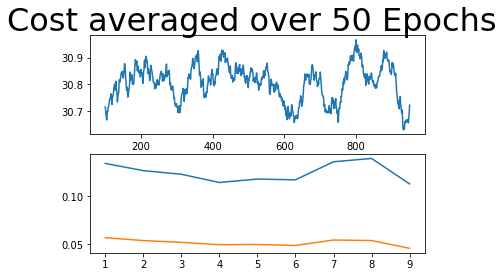

In [ ]:

fig, ax = plt.subplots(2)

fig.suptitle("Cost averaged over 50 Epochs", fontsize=32)

costs = np.array(cost_l)
dist_mean = np.array(dist_mean_inventory)
dist_price = np.array(dist_price_distortion)
average_costs = np.zeros(num_epochs - 50)
for i in range(num_epochs - 50):
  average_costs[i] = np.mean(costs[i:i+50])
ax[0].plot(np.arange(100, num_epochs - 50), average_costs[100:], label="Cost")
ax[1].plot(np.arange(int(100 / dist_epoch), int(num_epochs / dist_epoch)), dist_mean[int(100 / dist_epoch):], label="mean inventory")
ax[1].plot(np.arange(int(100 / dist_epoch), int(num_epochs / dist_epoch)),
           dist_price[int(100 / dist_epoch):], label="price distortion")


plt.show()


Comparison with exact solution

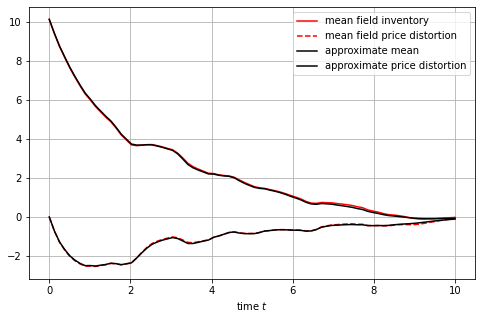

In [ ]:
# x_sol = z_sol[:,0]
# y_sol = z_sol[:,1]
# x1_sol = z_sol[:,2]
ts = np.linspace(0, trading_model.T +  trading_model.dt.cpu().numpy(), trading_model.T_idx + 1)

X_0 = trading_model.init_X()
I, P = trading_model.sample_signal()
X, Y, l = trading_model.sample_from_signal(X_0, I, P)
exact_model = Exact(trading_model)
trading_model.control_model = exact_model
X_e, Y_e, l_e = trading_model.sample_from_signal(X_0, I, P)
trading_model.control_model = control_model


# print(L2_dist(X, X_e))
# print(L2_dist(-trading_model.kappa * Y_e, -trading_model.kappa * Y))
plt.figure(figsize=(8,5))

# plt.plot(ts[:-1], x_sol, label = "mean field inventory", color = 'r')
# plt.plot(ts[:-1], -trading_model.kappa * y_sol, '--', label = "mean field price distortion", color = 'r')
plt.plot(ts[:-1], X_e[:-1,:,0].mean(axis=1).detach().cpu().numpy(), label = "mean field inventory", color = 'r')
plt.plot(ts[:-1], -trading_model.kappa * Y_e[:-1,0].detach().cpu().numpy(), '--', label = "mean field price distortion", color = 'r')
plt.plot(ts[:-1], X[:-1,:,0].mean(axis=1).detach().cpu().numpy(), '-', label = "approximate mean" , color = 'black')
plt.plot(ts[:-1], -trading_model.kappa * Y[:-1,0].detach().cpu().numpy(), '-', label = "approximate price distortion" , color = 'black')
# plt.plot(timeGrid, x2_sol, '-', color = 'black')
# plt.plot(timeGrid, x3_sol, '-', color = 'black')
# plt.plot(timeGrid, signal(timeGrid), '--', color = 'grey', label = "signal process $A_t$")
plt.legend()
plt.xlabel("time $t$")
# plt.ylabel("inventory")

plt.grid()

plt.show()

In [ ]:
# def L2_dist(x, y):
#   if len(x) != len(y):
#     print('Lengths not compatible.')
#     return
#   return np.sqrt(sum((x-y)*(x-y))/len(x))

In [ ]:
# with open(f"cost_l_Tidxs.pickle", 'wb') as f:
#   pickle.dump(cost_ls, f, protocol=pickle.HIGHEST_PROTOCOL)

# Experiment 1: varying T_idx

Times for below experiments were:
5: 2:05
10: 4:03
20: 7:49
40: 15:12
80: 30:02
160: 59:54

In [ ]:
num_epochs = 15000

T_idxs = [5, 10, 20, 40, 80, 160]
cost_ls = []

path = os.path.join('trading_data', 'TidxTest')

for T_idx in T_idxs:

  control_model = FFNet().to(device, dtype)
  trading_model = TradingModel(control_model, T_idx=T_idx)

  optimizer = torch.optim.Adam(control_model.parameters()) 

  cost_l = []

  for epoch in tqdm(range(num_epochs)):

    optimizer.zero_grad()
    cost_loss = trading_model.cost()
    cost_loss.backward()
    optimizer.step()
    cost_l.append(cost_loss.detach().item())

  name = f"control_model_({trading_model.N}, {trading_model.T_idx})epochs{num_epochs}.pth"
  torch.save(control_model.state_dict(), os.path.join(path, name))
  cost_ls.append(cost_l)

with open(os.path.join(path, f"cost_l_Tidxs.json"), 'w') as f:
  json.dump(cost_ls, f)

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [59:54<00:00,  4.17it/s]


In [ ]:
path = os.path.join('trading_data', 'TidxTest')

with open(os.path.join(path, f"cost_l_Tidxs.json"), 'r') as file:
    cost_ls = json.load(file)


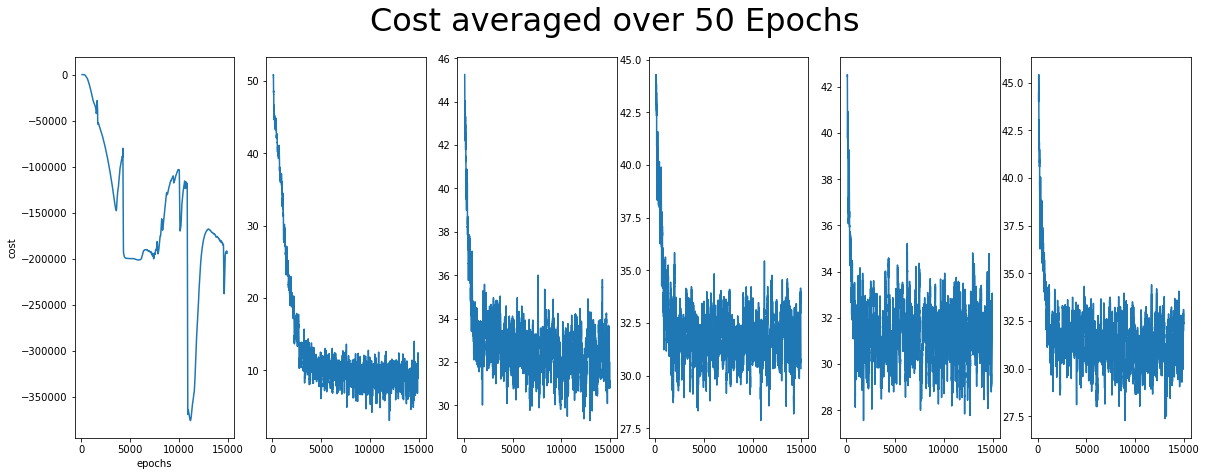

In [ ]:

fig, axs = plt.subplots(1, 6, figsize = (20, 7))
num_epochs = 15000
fig.suptitle("Cost averaged over 50 Epochs", fontsize=32)
for j in range(6):
  costs = np.array(cost_ls[j])
  average_costs = np.zeros(num_epochs - 50)
  for i in range(num_epochs - 50):
    average_costs[i] = np.mean(costs[i:i+50])
  axs[j].plot(np.arange(100, num_epochs - 50), average_costs[100:])

axs[0].set_ylabel('cost')
axs[0].set_xlabel('epochs')

plt.show()

FileNotFoundError: ignored

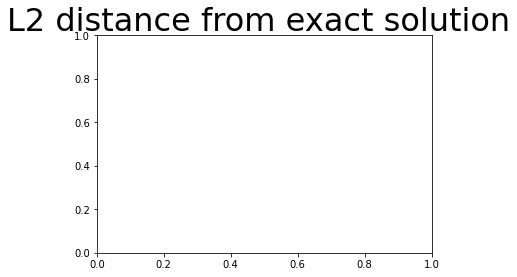

In [ ]:

fig, ax = plt.subplots(1)
fig.suptitle("L2 distance from exact solution", fontsize=32)

T_idxs = [5, 10, 20, 40, 80, 160]
num_epochs = 15000

dist_mean = []
dist_price = []

control_model = FFNet().to(device, dtype)

path = os.path.join('trading_data', 'TidxTest')
for T_idx in T_idxs:
  trading_model = TradingModel(control_model, T_idx=T_idx, batch_size=30)
  exact_model = Exact(trading_model)

  name = f"control_model_({trading_model.N}, {trading_model.T_idx})epochs{num_epochs}.pth"
  control_model.load_state_dict(torch.load(os.path.join(path, name)))

  X_0 = trading_model.init_X()
  I, P = trading_model.sample_signal()
  X, Y, l = trading_model.sample_from_signal(X_0, I, P)
  trading_model.control_model = exact_model
  X_e, Y_e, l_e = trading_model.sample_from_signal(X_0, I, P)
  trading_model.control_model = control_model
  dist_mean.append(L2_dist(X, X_e).mean().detach().item())
  dist_price.append(L2_dist(-trading_model.kappa * Y_e, -trading_model.kappa * Y).mean().detach().item())

ax.plot(T_idxs[1:], dist_mean[1:], label="L2 distance of mean inventory")
ax.plot(T_idxs[1:], dist_price[1:], label="L2 distance of price distortion")

ax.set_ylabel('distance')
ax.set_xlabel('T_idx')

ax.legend()

plt.show()

# Experiment 2: varying Ns

Time is very independent of N:

5: 29:05
10: 28:53
20: 28:47
30: 29:53
40: 29:53
80: 30:00
160: 30:45

In [ ]:
num_epochs = 15000

Ns = [5, 10, 20, 30, 40, 80, 160]
Ncost_ls = []

path = os.path.join('trading_data', 'NTest')

for N in Ns:

  control_model = FFNet().to(device, dtype)
  trading_model = TradingModel(control_model, N=N)

  optimizer = torch.optim.Adam(control_model.parameters()) 

  cost_l = []

  for epoch in tqdm(range(num_epochs)):

    optimizer.zero_grad()
    cost_loss = trading_model.cost()
    cost_loss.backward()
    optimizer.step()
    cost_l.append(cost_loss.detach().item())

  name = f"control_model_({trading_model.N}, {trading_model.T_idx})epochs{num_epochs}.pth"
  torch.save(control_model.state_dict(), os.path.join(path, name))
  Ncost_ls.append(cost_l)

with open(os.path.join(path, f"cost_l_Ns.json"), 'w') as f:
  json.dump(Ncost_ls, f)

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [30:45<00:00,  8.13it/s]


In [ ]:
path = os.path.join('trading_data', 'NTest')

with open(os.path.join(path, f"cost_l_Ns.json"), 'r') as f:
  Ncost_ls = json.load(f)


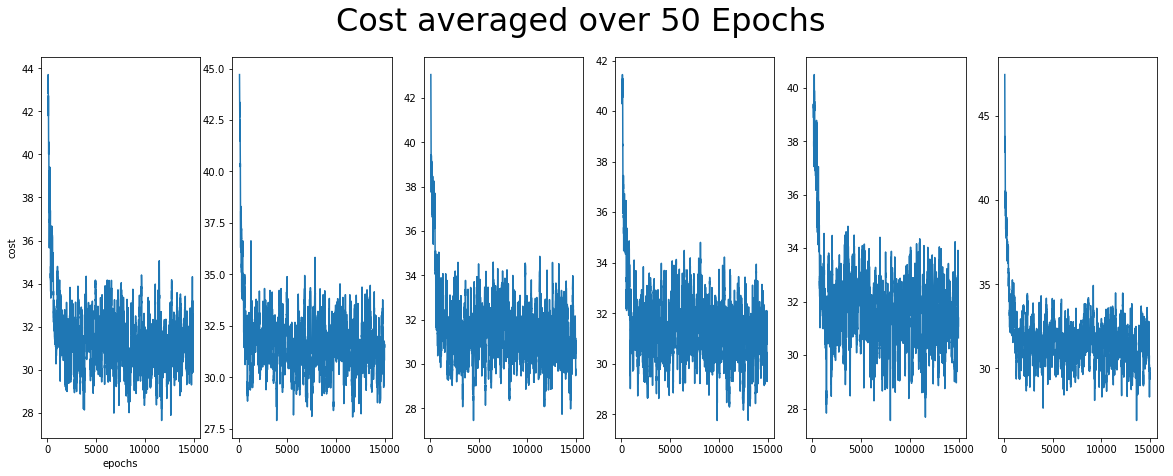

In [ ]:

fig, axs = plt.subplots(1, 6, figsize = (20, 7))
num_epochs = 15000
fig.suptitle("Cost averaged over 50 Epochs", fontsize=32)
for j in range(6):
  costs = np.array(Ncost_ls[j])
  average_costs = np.zeros(num_epochs - 50)
  for i in range(num_epochs - 50):
    average_costs[i] = np.mean(costs[i:i+50])
  axs[j].plot(np.arange(100, num_epochs - 50), average_costs[100:], label="Cost")

axs[0].set_xlabel('epochs')
axs[0].set_ylabel('cost')

plt.show()

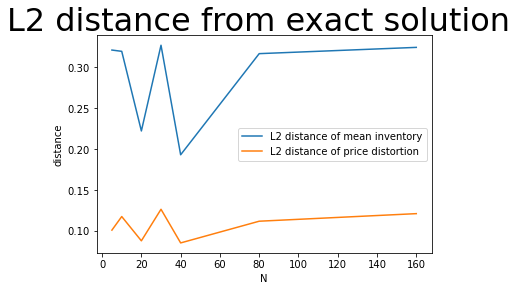

In [ ]:
fig, ax = plt.subplots(1)
fig.suptitle("L2 distance from exact solution", fontsize=32)

Ns = [5, 10, 20, 30, 40, 80, 160]
num_epochs = 15000

dist_mean = []
dist_price = []

control_model = FFNet().to(device, dtype)

path = os.path.join('trading_data', 'NTest')
for N in Ns:
  trading_model = TradingModel(control_model, N=N, batch_size=30)
  exact_model = Exact(trading_model)

  name = f"control_model_({trading_model.N}, {trading_model.T_idx})epochs{num_epochs}.pth"
  control_model.load_state_dict(torch.load(os.path.join(path, name)))

  X_0 = trading_model.init_X()
  I, P = trading_model.sample_signal()
  X, Y, l = trading_model.sample_from_signal(X_0, I, P)
  trading_model.control_model = exact_model
  X_e, Y_e, l_e = trading_model.sample_from_signal(X_0, I, P)
  trading_model.control_model = control_model
  dist_mean.append(L2_dist(X, X_e).mean().detach().item())
  dist_price.append(L2_dist(-trading_model.kappa * Y_e, -trading_model.kappa * Y).mean().detach().item())

ax.plot(Ns[0:], dist_mean[0:], label="L2 distance of mean inventory")
ax.plot(Ns[0:], dist_price[0:], label="L2 distance of price distortion")

ax.set_xlabel('N')
ax.set_ylabel('distance')

ax.legend()
plt.show()


# Experiment 3: Deterministic

In [ ]:

num_epochs = 30000
print_epoch = 100

path = os.path.join('trading_data', 'deterministic')


control_model = FFNet().to(device, dtype)
trading_model = TradingModel(control_model, sigma=0.0, batch_size=1)

optimizer = torch.optim.Adam(control_model.parameters()) 

Dcost_l = []

for epoch in tqdm(range(num_epochs)):

  optimizer.zero_grad()
  cost_loss = trading_model.cost()
  cost_loss.backward()
  optimizer.step()
  Dcost_l.append(cost_loss.detach().item())

  if (epoch + 1) % print_epoch == 0:
    name = os.path.join(path, f"control_model_({trading_model.N}, {trading_model.T_idx})epochs{epoch}.pth")
    torch.save(control_model.state_dict(), name)

with open(os.path.join(path, f"cost_l_D.json"), 'w') as f:
  json.dump(Dcost_l, f)

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [57:33<00:00,  8.69it/s]


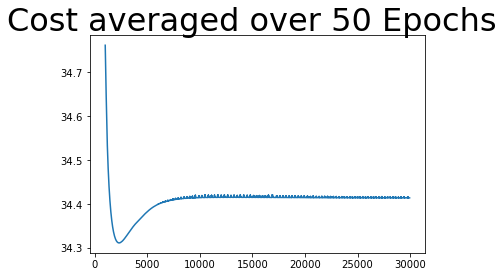

In [ ]:

fig, axs = plt.subplots()
num_epochs = 30000
fig.suptitle("Cost averaged over 50 Epochs", fontsize=32)

costs = np.array(Dcost_l)
average_costs = np.zeros(num_epochs - 50)
for i in range(num_epochs - 50):
  average_costs[i] = np.mean(costs[i:i+50])
axs.plot(np.arange(1000, num_epochs - 50), average_costs[1000:], label="Cost")

plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [03:05<00:00,  1.61it/s]


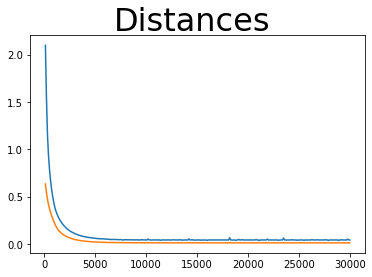

In [ ]:
path = os.path.join('trading_data', 'deterministic')

num_epochs = 30000
print_epoch = 100

control_model = FFNet().to(device, dtype)
trading_model = TradingModel(control_model, sigma=0.0, batch_size=1)
exact_model = Exact(trading_model)

dist_mean = []
dist_price = []

for print_e in tqdm(range(print_epoch - 1, num_epochs, print_epoch)):

  name = f"control_model_({trading_model.N}, {trading_model.T_idx})epochs{print_e}.pth"
  control_model.load_state_dict(torch.load(os.path.join(path, name)))

  X_0 = trading_model.init_X()
  I, P = trading_model.sample_signal()
  X, Y, l = trading_model.sample_from_signal(X_0, I, P)
  trading_model.control_model = exact_model
  X_e, Y_e, l_e = trading_model.sample_from_signal(X_0, I, P)
  trading_model.control_model = control_model
  dist_mean.append(L2_dist(X, X_e).mean().detach().item())
  dist_price.append(L2_dist(-trading_model.kappa * Y_e, -trading_model.kappa * Y).mean().detach().item())

with open(os.path.join(path, f"D_dist_mean.json"), 'w') as f:
  json.dump(dist_mean, f)

with open(os.path.join(path, f"D_dist_price.json"), 'w') as f:
  json.dump(dist_price, f)

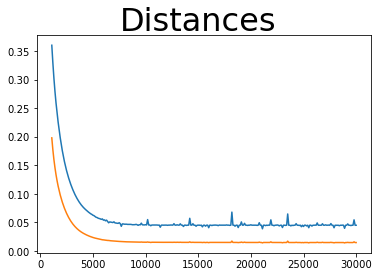

In [ ]:

fig, ax = plt.subplots()
fig.suptitle("Distances", fontsize=32)

p_E = range(print_epoch - 1, num_epochs, print_epoch)

ax.plot(p_E[10:], dist_mean[10:], label="L2 distance of mean inventory")
ax.plot(p_E[10:], dist_price[10:], label="L2 distance of price distortion")

plt.show()

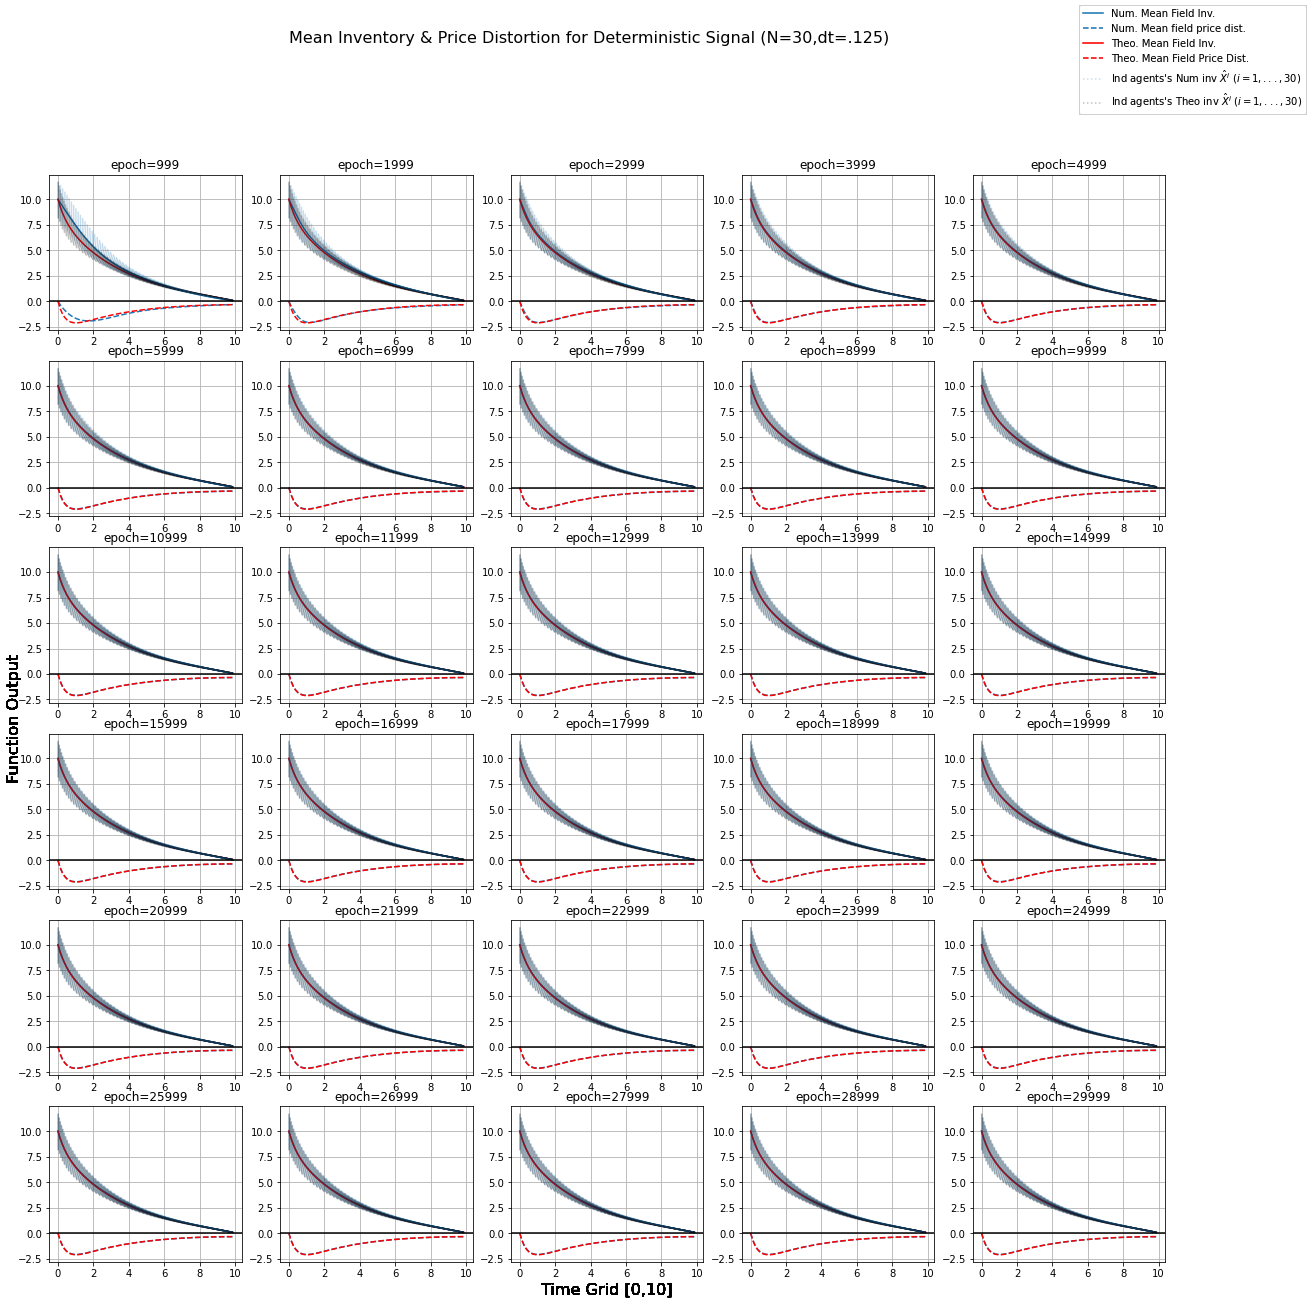

In [ ]:
epoch_total = 30

n = np.ceil(np.sqrt(epoch_total))
m = round(np.sqrt(epoch_total))
path = os.path.join('trading_data', 'deterministic')

fig, ax = plt.subplots(int(n), m, figsize = (20, 20))

control_model = FFNet().to(device, dtype)
trading_model = TradingModel(control_model, sigma=0.0, batch_size=1)
exact_model = Exact(trading_model)


X_0 = trading_model.init_X()
I, P = trading_model.sample_signal()
trading_model.control_model = exact_model
X_e, Y_e, l_e = trading_model.sample_from_signal(X_0, I, P)

for k, epoch in enumerate(range(1000 - 1, 30000, 1000)):
  
  name = f"control_model_({trading_model.N}, {trading_model.T_idx})epochs{epoch}.pth"
  control_model.load_state_dict(torch.load(os.path.join(path, name)))

  trading_model.control_model = control_model
  X, Y, l = trading_model.sample_from_signal(X_0, I, P)

  ind = (k//m, k%m)

  # Compare the numerical control with the theoretical optimal control

  mean_X = X[:-1,:,0].mean(axis=1).cpu().detach().numpy()
  mean_X_e = X_e[:-1,:,0].mean(axis=1).cpu().detach().numpy()


  ts = np.arange(0, trading_model.T_idx) * trading_model.dt.detach().cpu().numpy()

  ax[ind].plot(ts, mean_X, label="Num. Mean Field Inv.", color='tab:blue')
  ax[ind].plot(ts, -(trading_model.kappa * Y[:-1,0]).cpu().detach().numpy(), '--', label="Num. Mean field price dist.", color='tab:blue')
  # plt.plot(t[:T_idx], signalArray, label="signal process $A$", color='g')#[np.trapz(I[:i,0].cpu().detach().numpy(), t[:i]) for i in range(T_idx)])
  # ax[new_N, i].plot(t[:T_idx+1], P[:,0].detach().cpu().numpy(), label="P")
  # ax[new_N, i].plot(t[:T_idx+1], I[:,0].detach().cpu().numpy(), label="I")
  ax[ind].plot(ts, mean_X_e, label = "Theo. Mean Field Inv.", color = 'r')
  ax[ind].plot(ts, -(trading_model.kappa * Y_e[:-1,0]).cpu().detach().numpy(), '--', label = "Theo. Mean Field Price Dist.", color = 'r')
  for j in range(1, trading_model.N):
    ax[ind].plot(t, X[:-1,j,0].cpu().detach().numpy(), ':', color = 'tab:blue', alpha=.2)
    ax[ind].plot(t, X_e[:-1,j,0].cpu().detach().numpy(), ':', color = 'black', alpha=.2)
  ax[ind].plot(t, X[:-1,0,0].cpu().detach().numpy(), ':', label = "Ind agents's Num inv $\hat{X}^i$ $(i=1,...,30)$" , color = 'tab:blue', alpha=.2)
  ax[ind].plot(t, X_e[:-1,0,0].cpu().detach().numpy(), ':', label = "Ind agents's Theo inv $\hat{X}^i$ $(i=1,...,30)$" , color = 'black', alpha=.2)
  ax[ind].axhline(y=0, color='k')
  ax[ind].set_title(f'epoch={epoch}')
  ax[ind].grid(True)

  fig.suptitle("Mean Inventory & Price Distortion for Deterministic Signal (N=30,dt=.125)", fontsize=16)
  lines, labels = ax[0,0].get_legend_handles_labels()
  fig.legend(lines, labels)
  #common x/y labels
  fig.add_subplot(111, frameon=False)
  plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
  plt.grid(False)
  plt.xlabel("Time Grid [0,10]", fontsize=16)
  plt.ylabel("Function Output", fontsize=16)
  # plt.tight_layout()
  # plt.show()

# Experiment 4: $\alpha = 1/2$

In [ ]:
num_epochs = 1000
print_epoch = 100

# path = os.path.join('trading_data', 'alphaonehalfB')
path = ''


control_model = FFNet().to(device, dtype)
trading_model = TradingModel(control_model, T_idx=160, alpha=0.5, batch_size=1280)

optimizer = torch.optim.Adam(control_model.parameters()) 

cost_l = []

for epoch in tqdm(range(num_epochs)):

  optimizer.zero_grad()
  cost_loss = trading_model.cost()
  cost_loss.backward()
  optimizer.step()
  cost_l.append(cost_loss.detach().item())

  if (epoch + 1) % print_epoch == 0:
    name = os.path.join(path, f"control_model_({trading_model.N}, {trading_model.T_idx})epochs{epoch}.pth")
    torch.save(control_model.state_dict(), name)

with open(os.path.join(path, f"cost_l_alpha.json"), 'w') as f:
  json.dump(cost_l, f)

100%|██████████| 1000/1000 [06:13<00:00,  2.68it/s]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


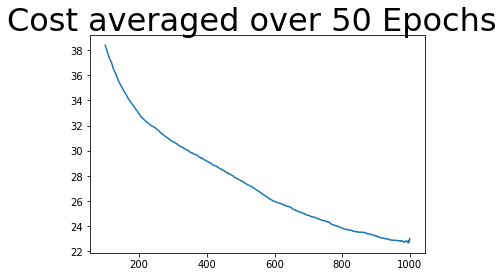

In [ ]:

fig, axs = plt.subplots()
num_epochs = 15000
fig.suptitle("Cost averaged over 50 Epochs", fontsize=32)

costs = np.array(cost_l)
average_costs = np.zeros(num_epochs - 50)
for i in range(num_epochs - 50):
  average_costs[i] = np.mean(costs[i:i+50])
axs.plot(np.arange(100, num_epochs - 50), average_costs[100:], label="Cost")

plt.show()

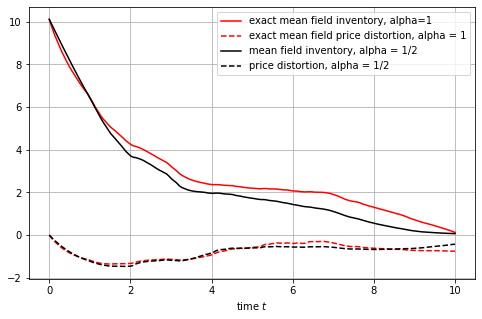

In [ ]:
# x_sol = z_sol[:,0]
# y_sol = z_sol[:,1]
# x1_sol = z_sol[:,2]
ts = np.linspace(0, trading_model.T +  trading_model.dt.cpu().numpy(), trading_model.T_idx + 1)
trading_model.batch_size = 1
X_0 = trading_model.init_X()
I, P = trading_model.sample_signal()
X, Y, l = trading_model.sample_from_signal(X_0, I, P)
exact_model = Exact(trading_model)
trading_model.control_model = exact_model
X_e, Y_e, l_e = trading_model.sample_from_signal(X_0, I, P)
trading_model.control_model = control_model


# print(L2_dist(X, X_e))
# print(L2_dist(-trading_model.kappa * Y_e, -trading_model.kappa * Y))
plt.figure(figsize=(8,5))

# plt.plot(ts[:-1], x_sol, label = "mean field inventory", color = 'r')
# plt.plot(ts[:-1], -trading_model.kappa * y_sol, '--', label = "mean field price distortion", color = 'r')
plt.plot(ts[:-1], X_e[:-1,:,0].mean(axis=1).detach().cpu().numpy(), label = "exact mean field inventory, alpha=1", color = 'r')
plt.plot(ts[:-1], -trading_model.kappa * Y_e[:-1,0].detach().cpu().numpy(), '--', label = "exact mean field price distortion, alpha = 1", color = 'r')
plt.plot(ts[:-1], X[:-1,:,0].mean(axis=1).detach().cpu().numpy(), '-', label = "mean field inventory, alpha = 1/2" , color = 'black')
plt.plot(ts[:-1], -trading_model.kappa * Y[:-1,0].detach().cpu().numpy(), '--', label = "price distortion, alpha = 1/2" , color = 'black')
# plt.plot(timeGrid, x2_sol, '-', color = 'black')
# plt.plot(timeGrid, x3_sol, '-', color = 'black')
# plt.plot(timeGrid, signal(timeGrid), '--', color = 'grey', label = "signal process $A_t$")
plt.legend()
plt.xlabel("time $t$")
# plt.ylabel("inventory")

plt.grid()

plt.show()

# Batch Experiment

In [ ]:
num_epochs = 5000
print_epoch = 100

batches = [5, 10, 20, 30, 40, 80, 160, 320, 640, 1280]
Bcost_ls = []
Bdist_mean_inventorys = []
Bdist_price_distortions = []

path = os.path.join('trading_data', 'batches')

for batch_s in batches:

  control_model = FFNet().to(device, dtype)
  trading_model = TradingModel(control_model, batch_size=batch_s)
  exact_model = Exact(trading_model)

  optimizer = torch.optim.Adam(control_model.parameters()) 

  cost_l = []
  Bdist_mean_inventory = []
  Bdist_price_distortion = []

  for epoch in tqdm(range(num_epochs)):

    optimizer.zero_grad()
    cost_loss = trading_model.cost()
    cost_loss.backward()
    optimizer.step()
    cost_l.append(cost_loss.detach().item())

    if (epoch + 1) % print_epoch == 0:
      with torch.no_grad():
        trading_model.batch_size = 30
        X_0 = trading_model.init_X()
        I, P = trading_model.sample_signal()
        X, Y, l = trading_model.sample_from_signal(X_0, I, P)
        trading_model.control_model = exact_model
        X_e, Y_e, l_e = trading_model.sample_from_signal(X_0, I, P)
        trading_model.control_model = control_model
        Bdist_mean_inventory.append(L2_dist(X, X_e).mean().detach().item())
        Bdist_price_distortion.append(L2_dist(-trading_model.kappa * Y_e, -trading_model.kappa * Y).mean().detach().item())
        trading_model.batch_size = batch_s
      name = os.path.join(path,f"control_model_batch_{batch_s}_epochs_{epoch + 1}.pth")
      torch.save(control_model.state_dict(), name)
  Bcost_ls.append(cost_l)
  Bdist_mean_inventorys.append(Bdist_mean_inventory)
  Bdist_price_distortions.append(Bdist_price_distortion)

with open(f"cost_l_Bs.pickle", 'wb') as f:
  pickle.dump(Bcost_ls, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(f"mean_inv_Bs.pickle", 'wb') as f:
  pickle.dump(Bdist_mean_inventorys, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(f"mean_price_Bs.pickle", 'wb') as f:
  pickle.dump(Bdist_price_distortions, f, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [14:52<00:00,  5.60it/s]


In [ ]:
path = os.path.join('trading_data', 'batches')

# with open(os.path.join(path, 'cost_l_Bs.json'), 'r') as file:
#     Bcost_ls = json.load(file)

# with open(os.path.join(path, 'mean_inv_Bs.json'), 'r') as file:
#     Bdist_mean_inventorys = json.load(file)

with open(os.path.join(path, 'mean_price_Bs.json'), 'r') as file:
    Bdist_price_distortions = json.load(file)


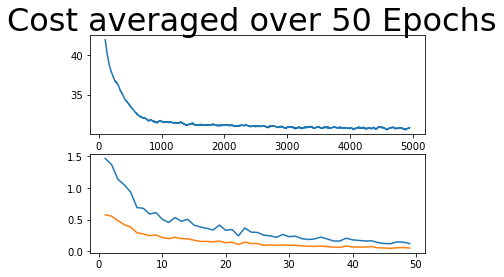

In [ ]:
num_epochs = 5000
dist_epoch = 100
fig, ax = plt.subplots(2)

j = 9

fig.suptitle("Cost averaged over 50 Epochs", fontsize=32)

costs = np.array(Bcost_ls[j])
dist_mean = np.array(Bdist_mean_inventorys[j])
dist_price = np.array(Bdist_price_distortions[j])
average_costs = np.zeros(num_epochs - 50)
for i in range(num_epochs - 50):
  average_costs[i] = np.mean(costs[i:i+50])
ax[0].plot(np.arange(100, num_epochs - 50), average_costs[100:], label="Cost")
ax[1].plot(np.arange(int(100 / dist_epoch), int(num_epochs / dist_epoch)), dist_mean[int(100 / dist_epoch):], label="mean inventory")
ax[1].plot(np.arange(int(100 / dist_epoch), int(num_epochs / dist_epoch)),
           dist_price[int(100 / dist_epoch):], label="price distortion")


plt.show()

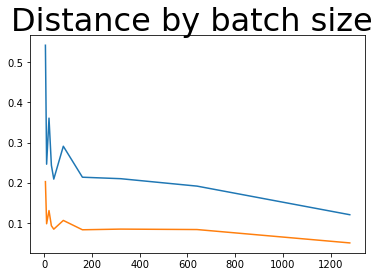

In [ ]:
costs = np.array(Bcost_ls)
dist_mean = np.array(Bdist_mean_inventorys)
dist_price = np.array(Bdist_price_distortions)

batches = [5, 10, 20, 30, 40, 80, 160, 320, 640, 1280]
fig, ax = plt.subplots(1)

fig.suptitle("Distance by batch size", fontsize=32)



ax.plot(batches, dist_mean[:,-1], label="Mean inventory L2 distance")
ax.plot(batches, dist_price[:,-1], label="Mean inventory L2 distance")



plt.show()

In [ ]:
A = np.array([1, 2])
print(A)

[1 2]


In [ ]:
B = np.zeros(2)
B[:] = A
print(B)

[1. 2.]


In [ ]:
A[0] = 0
print(A)

[0 2]


In [ ]:
print(B)

[1. 2.]


In [ ]:
# Do one run with ReLU ...

In [ ]:
# Do one with mean field control??